In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score,classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, accuracy_score, roc_auc_score
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
sns.set_theme()

In [2]:
!pip install MissForest

In [3]:
df = pd.read_excel('/content/sample_data/telecom_customer_churn.xlsx')
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

In [5]:
100 * df.isnull().sum().sort_values(ascending=False)/len(df)

Churn Reason                         73.463013
Churn Category                       73.463013
Internet Type                        21.666903
Unlimited Data                       21.666903
Streaming Music                      21.666903
Streaming Movies                     21.666903
Streaming TV                         21.666903
Premium Tech Support                 21.666903
Device Protection Plan               21.666903
Online Security                      21.666903
Avg Monthly GB Download              21.666903
Online Backup                        21.666903
Multiple Lines                        9.683374
Avg Monthly Long Distance Charges     9.683374
Phone Service                         0.000000
Contract                              0.000000
Age                                   0.000000
Customer Status                       0.000000
Total Revenue                         0.000000
Total Long Distance Charges           0.000000
Total Extra Data Charges              0.000000
Total Refunds

In [6]:
df.drop(columns=['Churn Reason', 'Churn Category', 'Zip Code', 'Latitude', 'Longitude'], inplace = True)

In [7]:
size_before = len(df)
df = df.drop_duplicates()
size_after = len(df)
print(str(size_before - size_after) + " dòng đã xóa")

0 dòng đã xóa


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7043.0,46.509726,16.750352,19.00,32.000,46.00,60.000,80.00
Number of Dependents,7043.0,0.468692,0.962802,0.00,0.000,0.00,0.000,9.00
Number of Referrals,7043.0,1.951867,3.001199,0.00,0.000,0.00,3.000,11.00
Tenure in Months,7043.0,32.386767,24.542061,1.00,9.000,29.00,55.000,72.00
Avg Monthly Long Distance Charges,6361.0,25.420517,14.200374,1.01,13.050,25.69,37.680,49.99
Avg Monthly GB Download,5517.0,26.189958,19.586585,2.00,13.000,21.00,30.000,85.00
Monthly Charge,7043.0,63.596131,31.204743,-10.00,30.400,70.05,89.750,118.75
Total Charges,7043.0,2280.381264,2266.220462,18.80,400.150,1394.55,3786.600,8684.80
Total Refunds,7043.0,1.962182,7.902614,0.00,0.000,0.00,0.000,49.79
Total Extra Data Charges,7043.0,6.860713,25.104978,0.00,0.000,0.00,0.000,150.00


In [9]:
df.describe(include='object').T

,count,unique,top,freq
Customer ID,7043,7043,0002-ORFBO,1
Gender,7043,2,Male,3555
Married,7043,2,No,3641
City,7043,1106,Los Angeles,293
Offer,7043,6,None,3877
Phone Service,7043,2,Yes,6361
Multiple Lines,6361,2,No,3390
Internet Service,7043,2,Yes,5517
Internet Type,5517,3,Fiber Optic,3035
Online Security,5517,2,No,3498


In [10]:
# Hàm phân loại nhóm khách hàng dựa trên tuổi
def classify_customer_age(age):
    if age < 35:
        return "Trẻ tuổi"
    elif age >= 35 and age < 65:
        return "Trung niên"
    else:
        return "Lớn tuổi"

# Hàm phân loại nhóm khách hàng có người phụ thuộc hay không
def classify_customer_dependents(depent):
  if depent > 0:
    return "Yes"
  return "No"

# Thêm cột vào tập dữ liệu
df['SeniorCitizen'] = df['Age'].apply(classify_customer_age)
df['Dependents'] = df['Number of Dependents'].apply(classify_customer_dependents)
df.drop(columns=['Age', 'Number of Dependents'], inplace=True)

In [11]:
df.head(5)

,Customer ID,Gender,Married,City,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,SeniorCitizen,Dependents
0,0002-ORFBO,Female,Yes,Frazier Park,2,9,None,Yes,42.39,No,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,Trung niên,No
1,0003-MKNFE,Male,No,Glendale,0,9,None,Yes,10.69,Yes,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,Trung niên,No
2,0004-TLHLJ,Male,No,Costa Mesa,0,4,Offer E,Yes,33.65,No,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Trung niên,No
3,0011-IGKFF,Male,Yes,Martinez,1,13,Offer D,Yes,27.82,No,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Lớn tuổi,No
4,0013-EXCHZ,Female,Yes,Camarillo,3,3,None,Yes,7.38,No,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Lớn tuổi,No


<ipython-input-12-9a046220ec4a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='pastel')


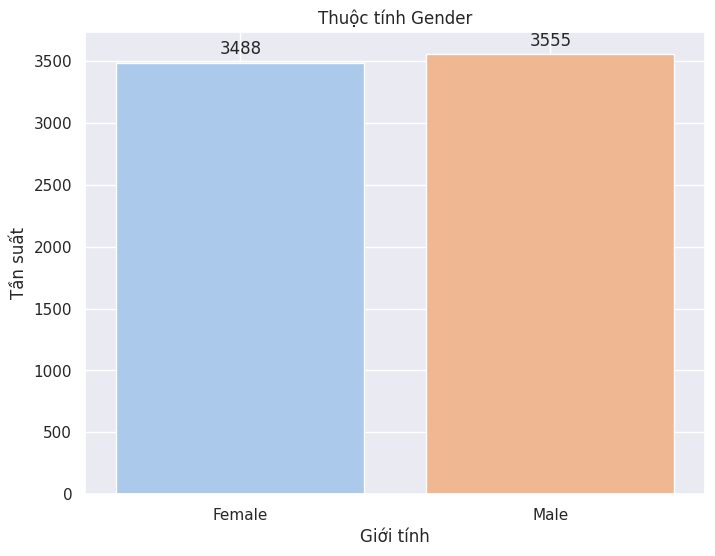

In [12]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Gender', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Gender')
plt.xlabel('Giới tính')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Gender.png', bbox_inches='tight')
plt.show()

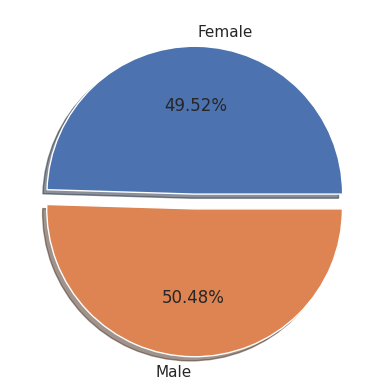

In [13]:
sizes = [df.Gender[df['Gender']=='Female'].count(),df.Gender[df['Gender']=='Male'].count()]
labels = ['Female', 'Male']
plt.pie(sizes, labels = labels, explode = (0,0.1), shadow=True, autopct='%.2f%%')
plt.savefig('Tron_Gender.png', bbox_inches='tight')
plt.show()

<ipython-input-14-d6cf7fbe97e0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='SeniorCitizen', palette='pastel')


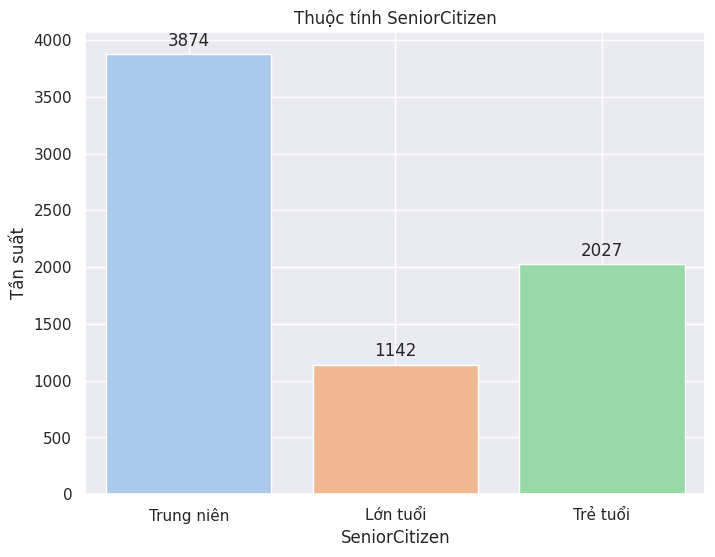

In [14]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='SeniorCitizen', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính SeniorCitizen')
plt.xlabel('SeniorCitizen')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('SeniorCitizen.png', bbox_inches='tight')
plt.show()

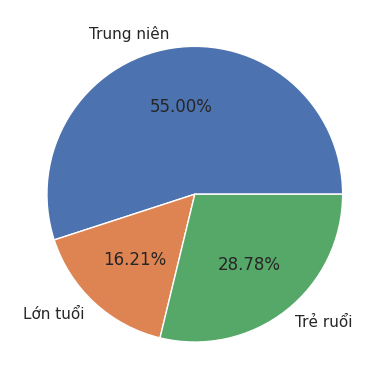

In [15]:
sizes = [df.SeniorCitizen[df['SeniorCitizen']=='Trung niên'].count(),df.SeniorCitizen[df['SeniorCitizen']=='Lớn tuổi'].count(),df.SeniorCitizen[df['SeniorCitizen']=='Trẻ tuổi'].count()]
labels = ['Trung niên', 'Lớn tuổi', 'Trẻ ruổi']
plt.pie(sizes, labels = labels, explode = (0,0,0), shadow=False, autopct='%.2f%%')
plt.savefig('Tron_SeniorCitizen.png', bbox_inches='tight')
plt.show()

<ipython-input-16-d2fb379a22e9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Dependents', palette='pastel')


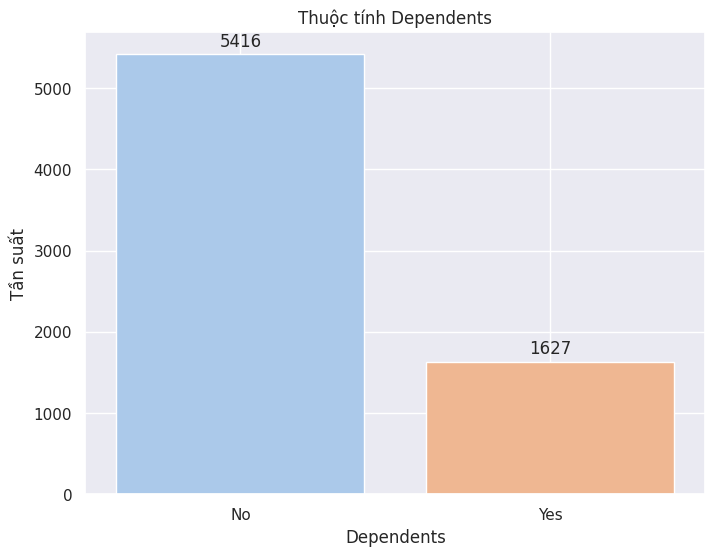

In [16]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Dependents', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Dependents')
plt.xlabel('Dependents')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Dependents.png', bbox_inches='tight')
plt.show()

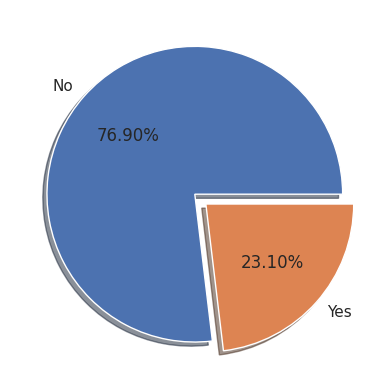

In [17]:
sizes = [df.Dependents[df['Dependents']=='No'].count(),df.Dependents[df['Dependents']=='Yes'].count()]
labels = ['No', 'Yes']
plt.pie(sizes, labels = labels, explode = (0,0.1), shadow=True, autopct='%.2f%%')
plt.savefig('Tron_Dependents.png', bbox_inches='tight')
plt.show()

<ipython-input-18-2991979f8421>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Contract', palette='pastel')


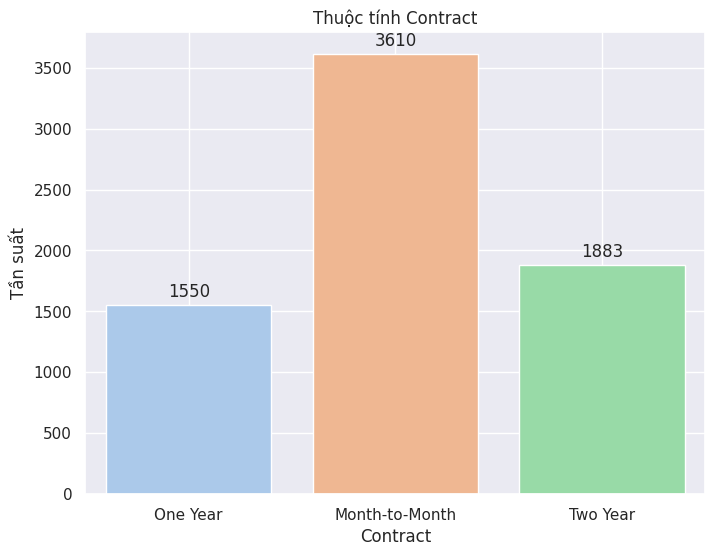

In [18]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Contract', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Contract')
plt.xlabel('Contract')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Contract.png', bbox_inches='tight')
plt.show()

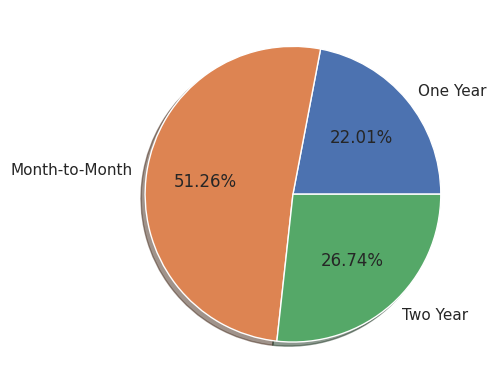

In [19]:
sizes = [df.Contract[df['Contract']=='One Year'].count(),df.Contract[df['Contract']=='Month-to-Month'].count(),df.Contract[df['Contract']=='Two Year'].count()]
labels = ['One Year', 'Month-to-Month', 'Two Year']
plt.pie(sizes, labels = labels, explode = (0,0,0), shadow=True, autopct='%.2f%%')
plt.savefig('Tron_Contract.png', bbox_inches='tight')
plt.show()

<ipython-input-20-96dd7e25eecb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Payment Method', palette='pastel')


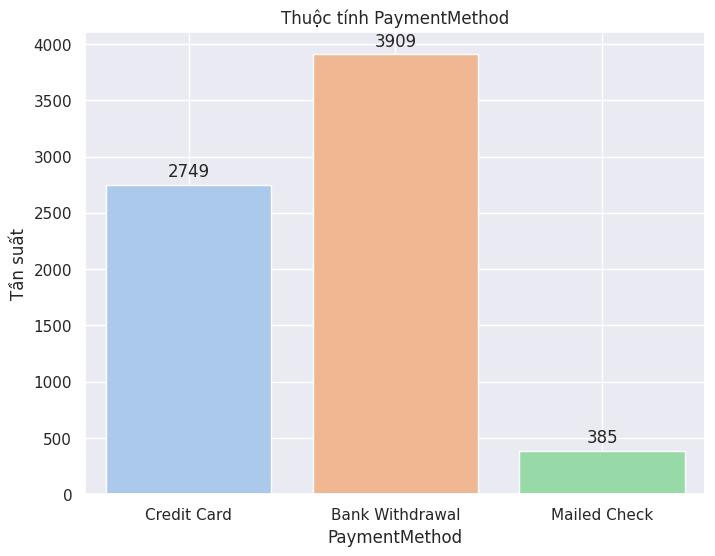

In [20]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Payment Method', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính PaymentMethod')
plt.xlabel('PaymentMethod')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('PaymentMethod.png', bbox_inches='tight')
plt.show()

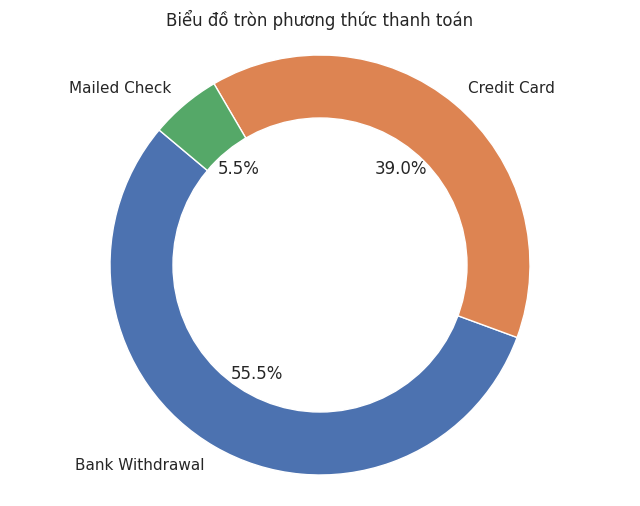

In [21]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Payment Method'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn phương thức thanh toán')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_PaymentMethod.png', bbox_inches='tight')
plt.show()

<ipython-input-22-e1192fd109c3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Phone Service', palette='pastel')


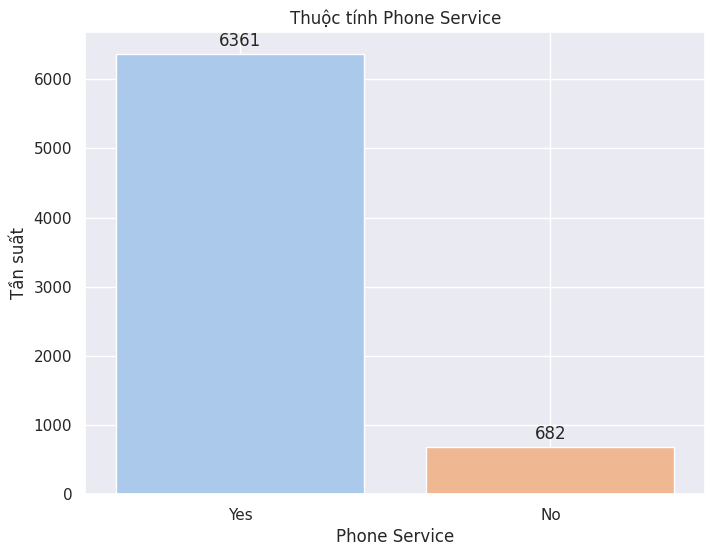

In [22]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Phone Service', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Phone Service')
plt.xlabel('Phone Service')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Phone Service.png', bbox_inches='tight')
plt.show()

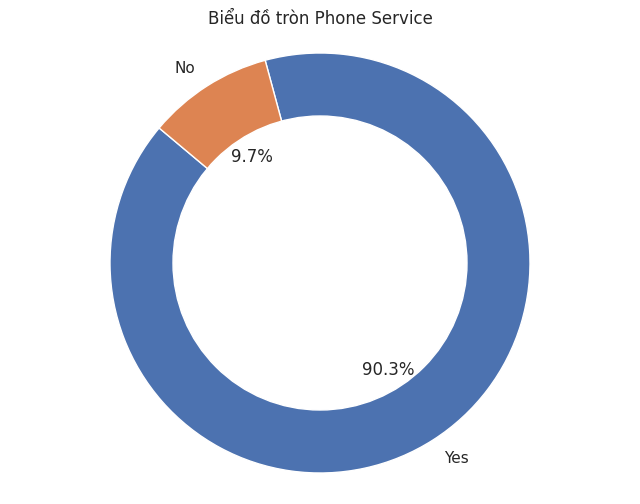

In [23]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Phone Service'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Phone Service')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Phone Service.png', bbox_inches='tight')
plt.show()

<ipython-input-24-a7b685e79e50>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Multiple Lines', palette='pastel')


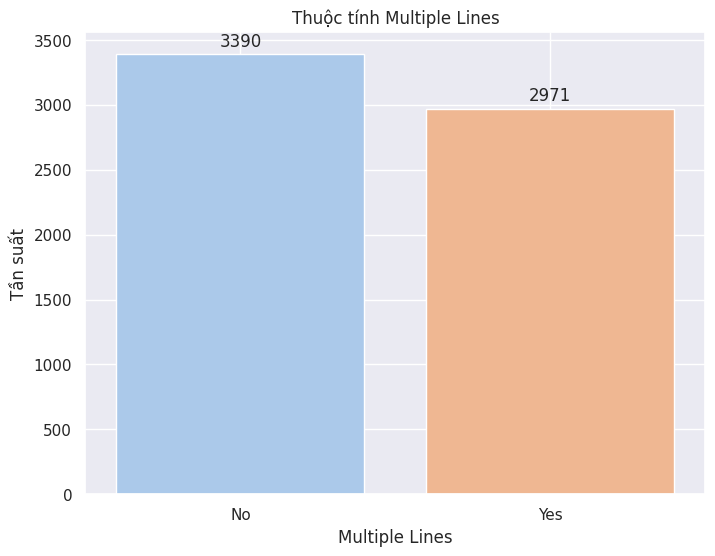

In [24]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Multiple Lines', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Multiple Lines')
plt.xlabel('Multiple Lines')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Multiple Lines.png', bbox_inches='tight')
plt.show()

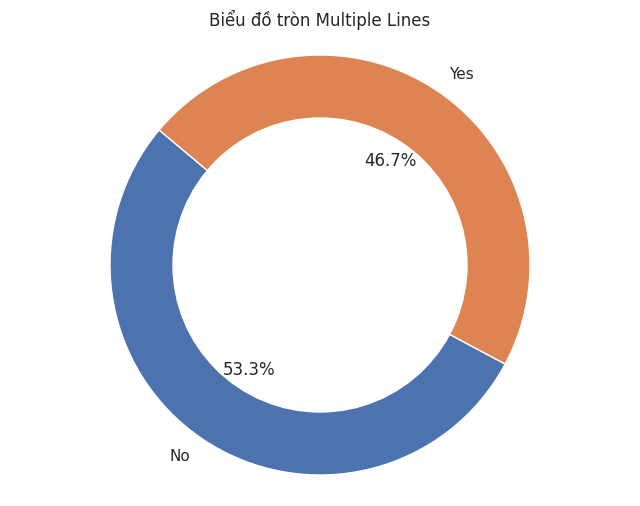

In [25]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Multiple Lines'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Multiple Lines')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Multiple Lines.png', bbox_inches='tight')
plt.show()

<ipython-input-26-c3ce928480c5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Internet Service', palette='pastel')


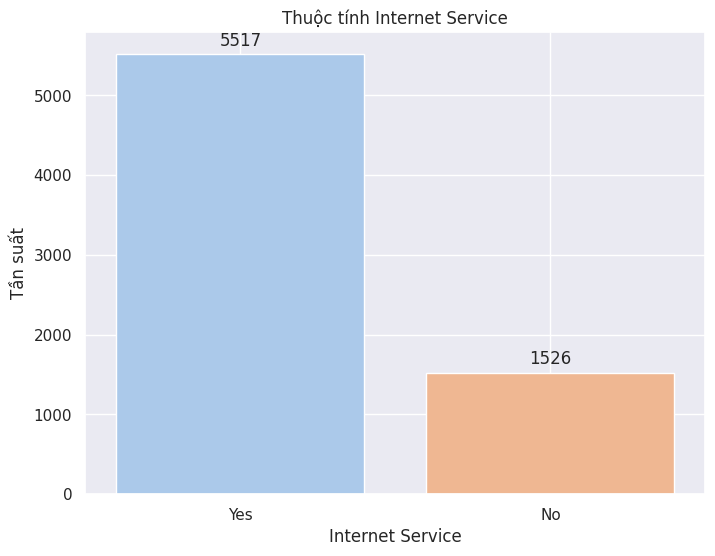

In [26]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Internet Service', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Internet Service.png', bbox_inches='tight')
plt.show()

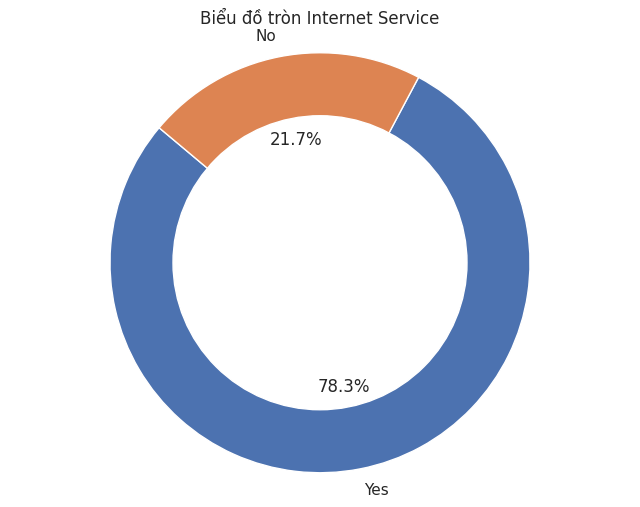

In [27]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Internet Service'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Internet Service')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Internet Service.png', bbox_inches='tight')
plt.show()

<ipython-input-28-bae2871c86cf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Online Security', palette='pastel')


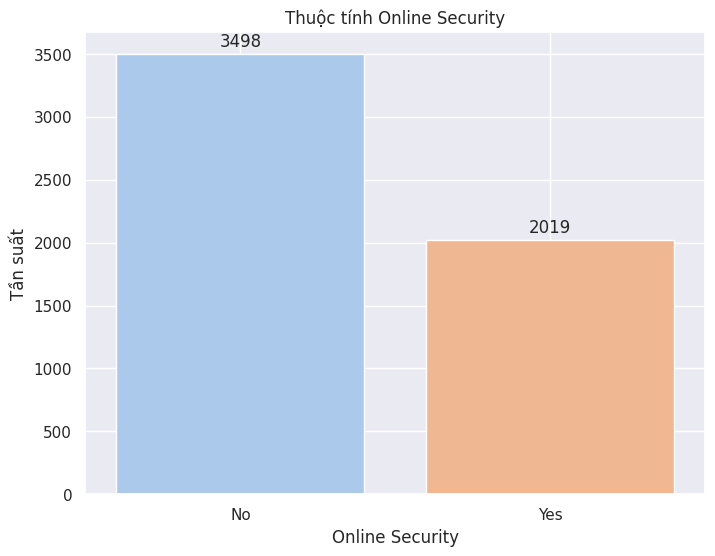

In [28]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Online Security', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Online Security')
plt.xlabel('Online Security')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Online Security.png', bbox_inches='tight')
plt.show()

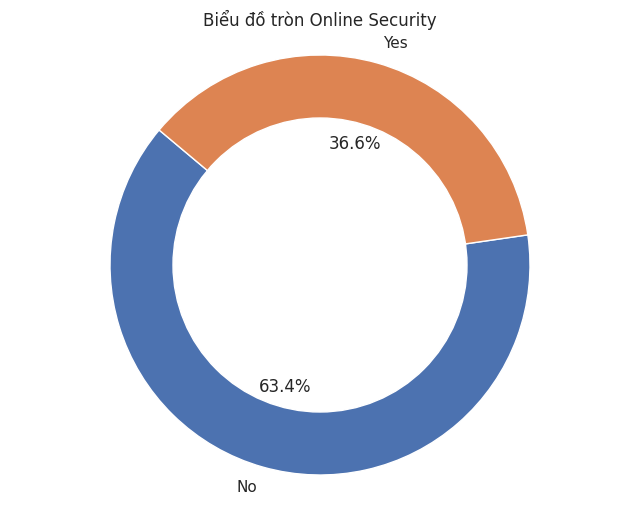

In [35]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Online Security'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Online Security')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Online Security.png', bbox_inches='tight')
plt.show()

<ipython-input-29-44678a507892>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Online Backup', palette='pastel')


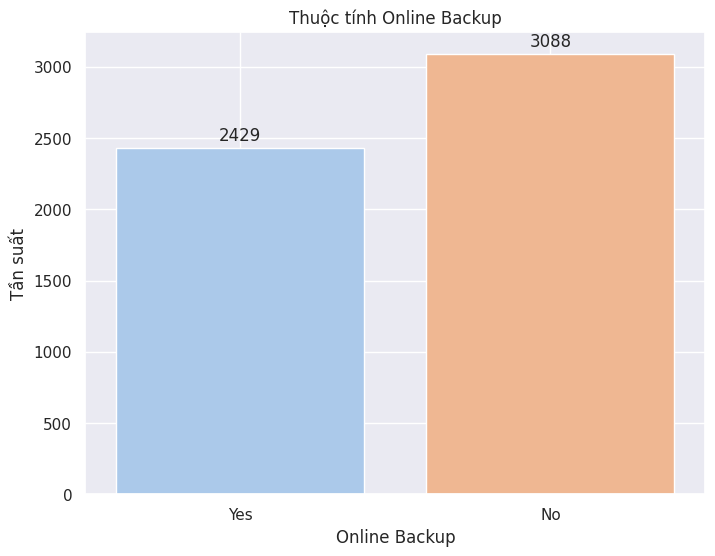

In [29]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Online Backup', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Online Backup')
plt.xlabel('Online Backup')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Online Backup.png', bbox_inches='tight')
plt.show()

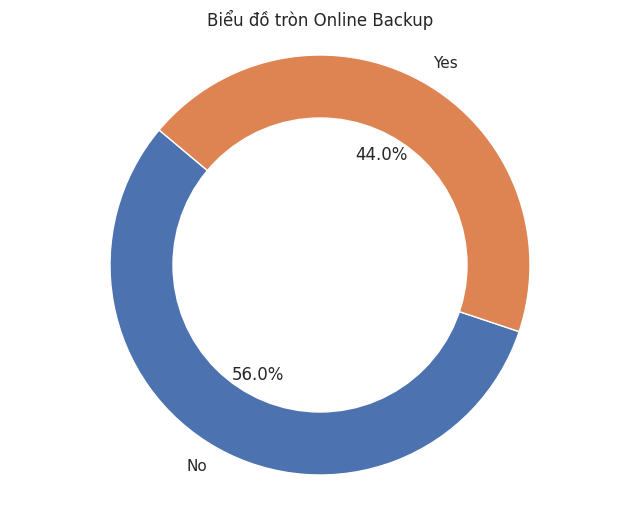

In [36]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Online Backup'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Online Backup')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Online Backup.png', bbox_inches='tight')
plt.show()

<ipython-input-30-fb1ef18f1d8d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Device Protection Plan', palette='pastel')


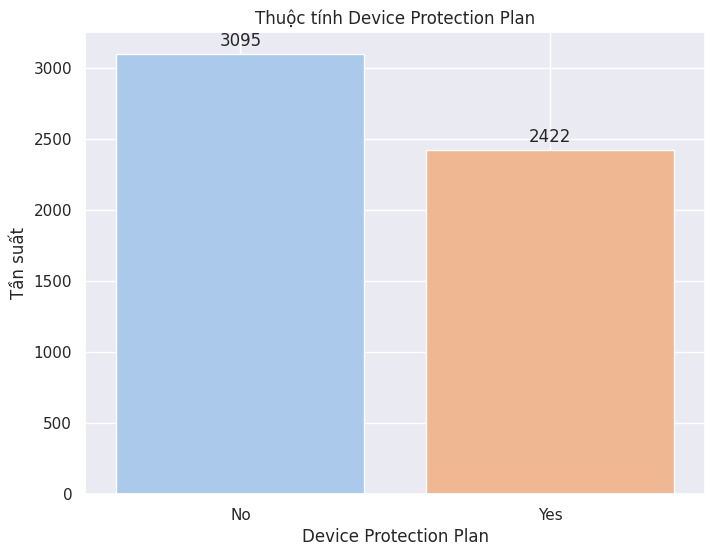

In [30]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Device Protection Plan', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Device Protection Plan')
plt.xlabel('Device Protection Plan')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Device Protection Plan.png', bbox_inches='tight')
plt.show()

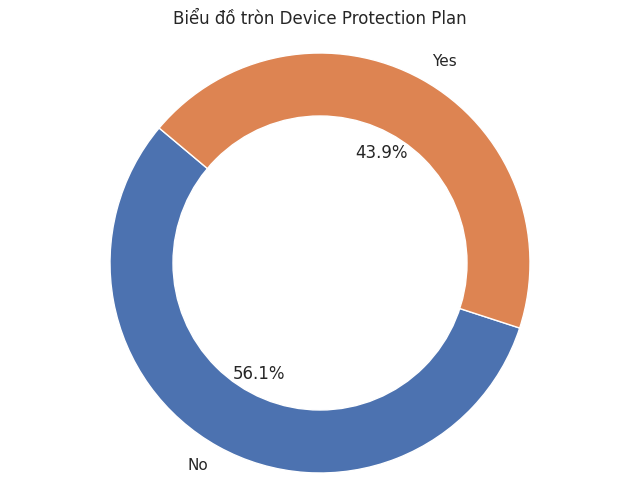

In [37]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Device Protection Plan'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Device Protection Plan')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Device Protection Plan.png', bbox_inches='tight')
plt.show()

<ipython-input-31-b9d2ebee26a7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Premium Tech Support', palette='pastel')


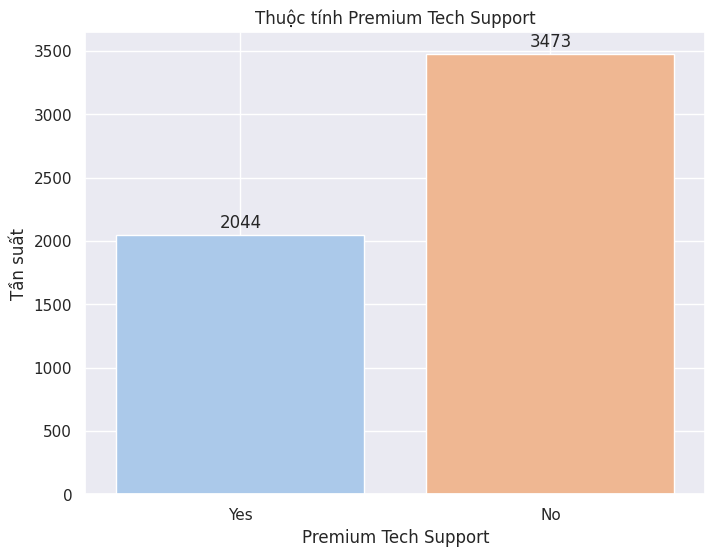

In [31]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Premium Tech Support', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Premium Tech Support')
plt.xlabel('Premium Tech Support')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Premium Tech Support.png', bbox_inches='tight')
plt.show()

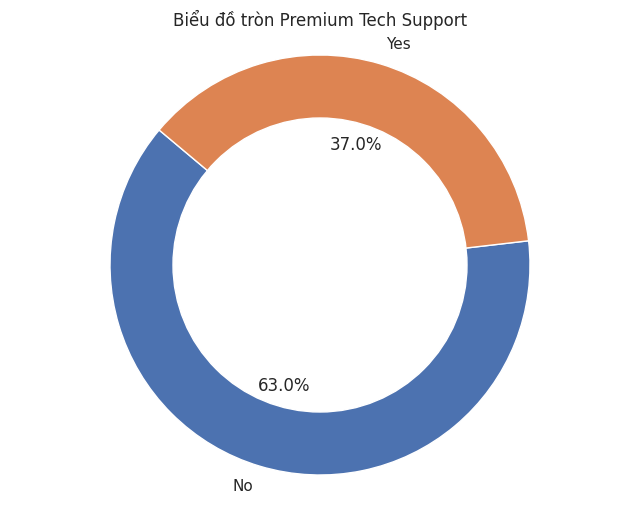

In [38]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Premium Tech Support'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Premium Tech Support')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Premium Tech Support.png', bbox_inches='tight')
plt.show()

<ipython-input-32-6d06ad6e6eee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Streaming TV', palette='pastel')


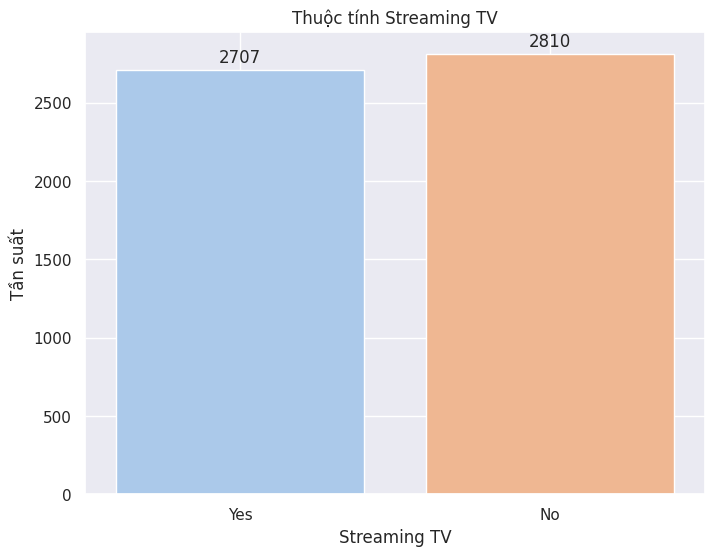

In [32]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Streaming TV', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Streaming TV')
plt.xlabel('Streaming TV')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Streaming TV.png', bbox_inches='tight')
plt.show()

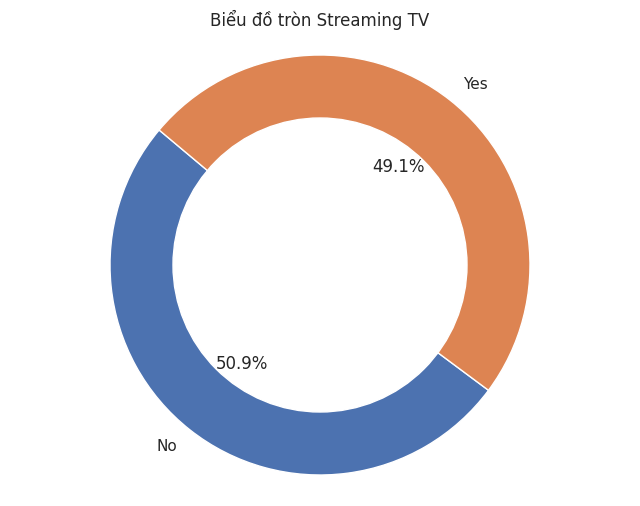

In [39]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Streaming TV'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Streaming TV')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Streaming TV.png', bbox_inches='tight')
plt.show()

<ipython-input-33-d8bc516aed2f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Streaming Movies', palette='pastel')


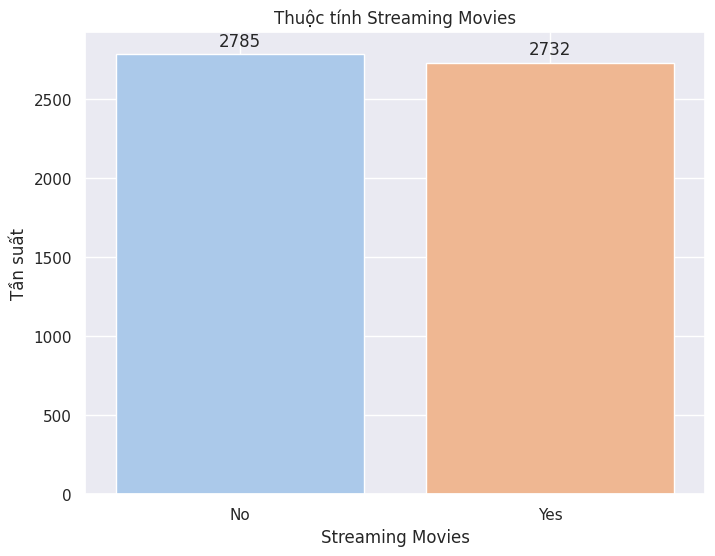

In [33]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Streaming Movies', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Streaming Movies')
plt.xlabel('Streaming Movies')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Streaming Movies.png', bbox_inches='tight')
plt.show()

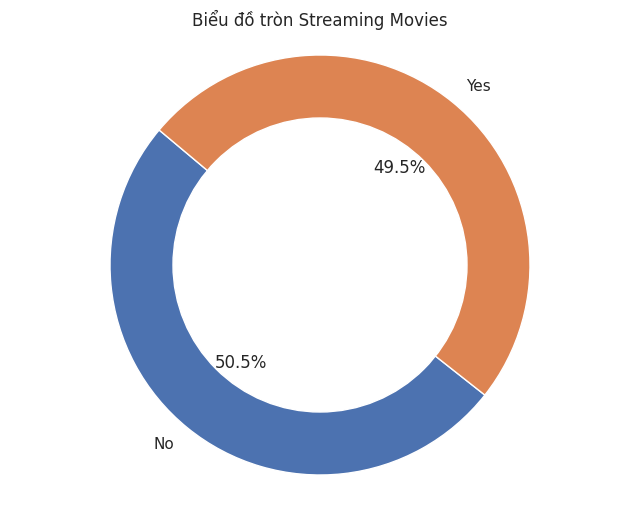

In [40]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Streaming Movies'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Streaming Movies')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Streaming Movies.png', bbox_inches='tight')
plt.show()

<ipython-input-34-15a61f8e50c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Streaming Music', palette='pastel')


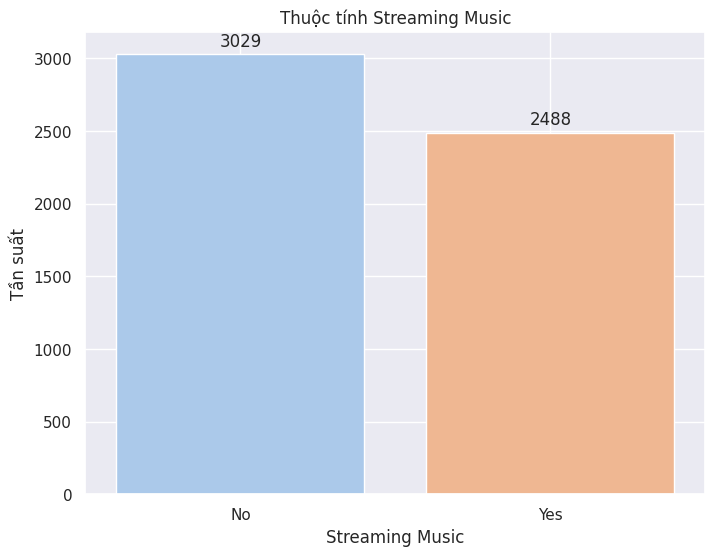

In [34]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Streaming Music', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Streaming Music')
plt.xlabel('Streaming Music')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Streaming Music.png', bbox_inches='tight')
plt.show()

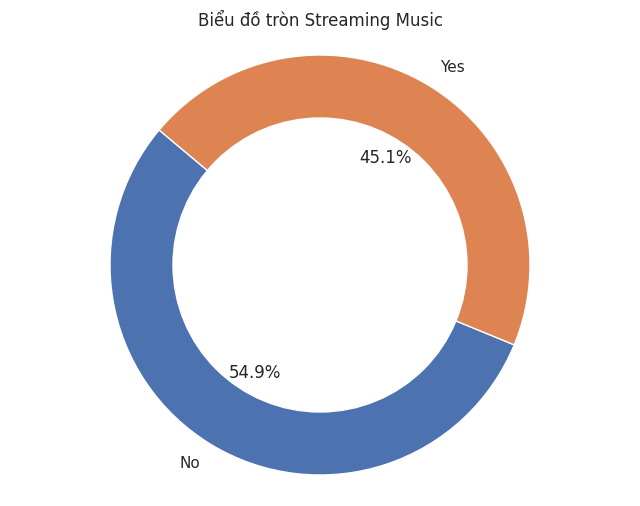

In [41]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Streaming Music'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Streaming Music')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Streaming Music.png', bbox_inches='tight')
plt.show()

<ipython-input-42-5058cca5e3b3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Customer Status', palette='pastel')


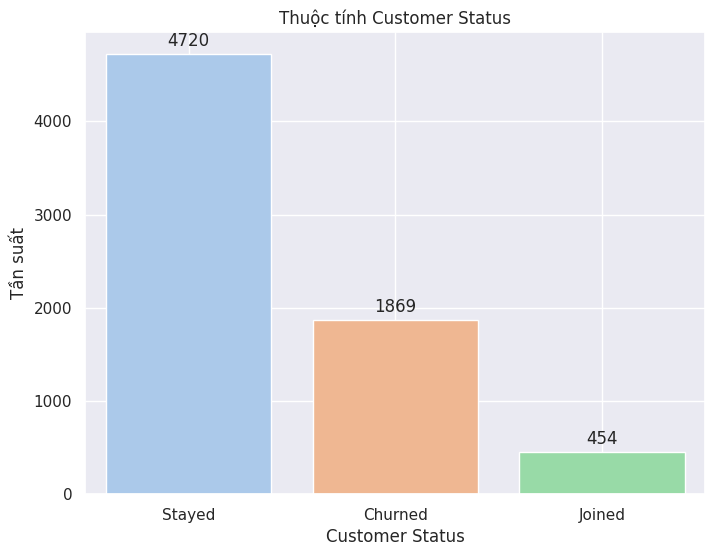

In [42]:
# Vẽ biểu đồ cột cho thuộc tính 'Gender'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Customer Status', palette='pastel')

# Thêm giá trị trên mỗi cột
for patch in plt.gca().patches:
    height = patch.get_height()
    plt.gca().annotate('{}'.format(int(height)), xy=(patch.get_x() + patch.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Thuộc tính Customer Status')
plt.xlabel('Customer Status')
plt.ylabel('Tần suất')
plt.grid(True)
plt.savefig('Customer Status.png', bbox_inches='tight')
plt.show()

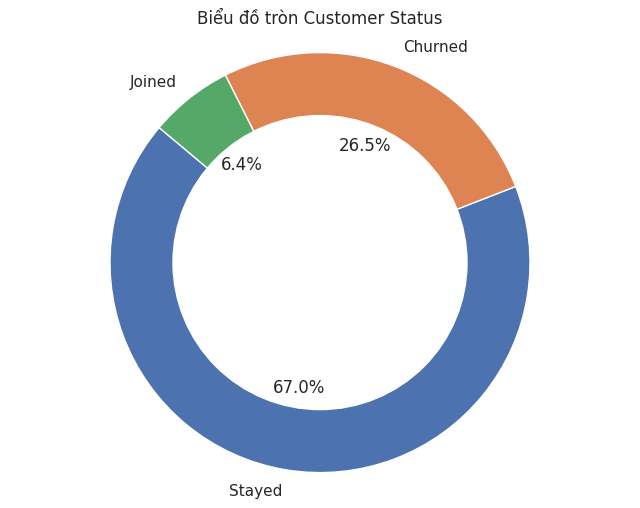

In [43]:
# Tính toán số lượng của mỗi phương thức thanh toán
payment_counts = df['Customer Status'].value_counts()

# Lấy các nhãn và các giá trị từ series
labels = payment_counts.index
sizes = payment_counts.values

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Tạo một hình tròn ở giữa để tạo thành biểu đồ tròn
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Biểu đồ tròn Customer Status')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.savefig('Tron_Customer Status.png', bbox_inches='tight')
plt.show()

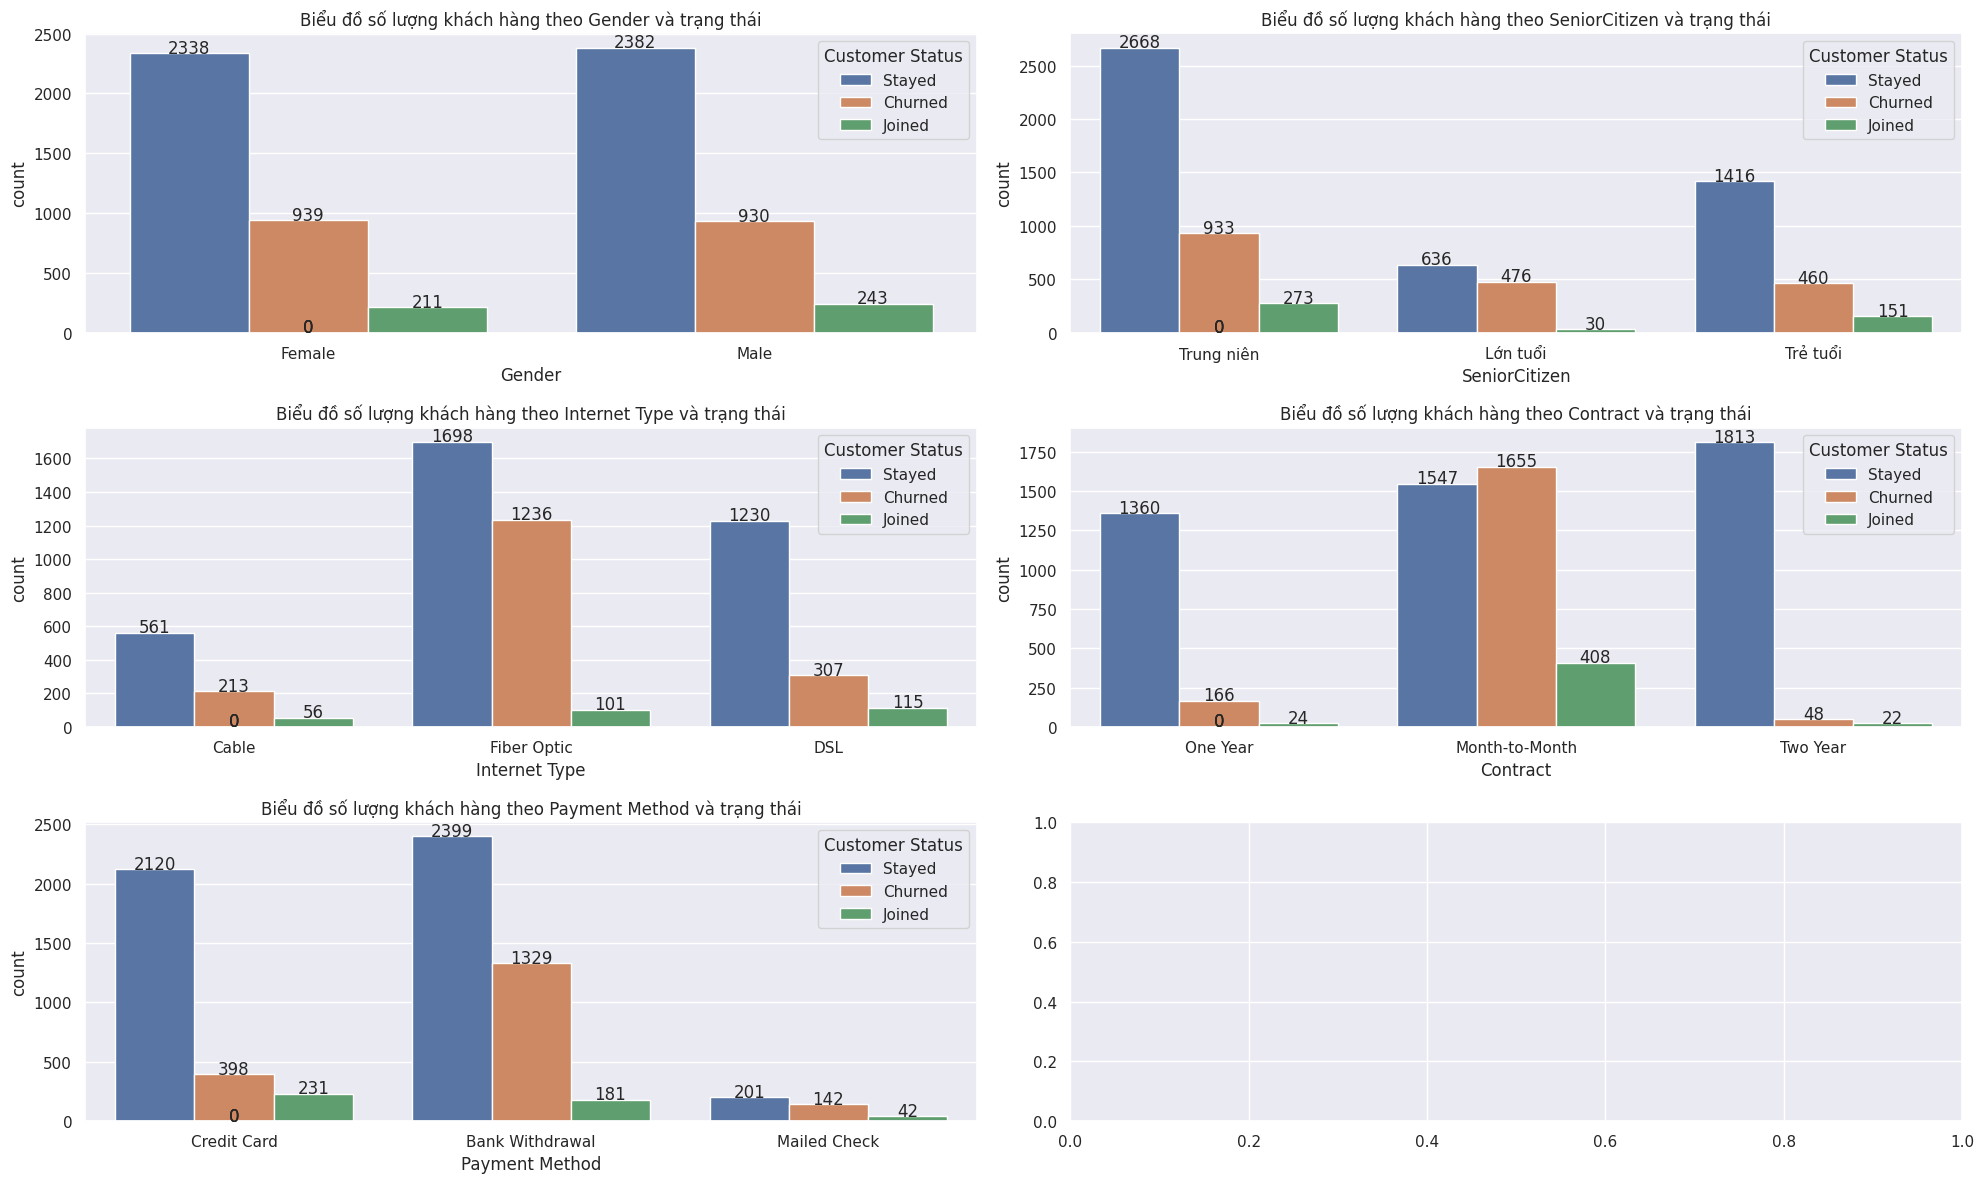

In [59]:
# Tạo subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 12))

# Vẽ từng biểu đồ và thêm tiêu đề, chú thích
for i, (ax, col) in enumerate(zip(axes.flatten(), ['Gender', 'SeniorCitizen', 'Internet Type', 'Contract', 'Payment Method'])):
    sns.countplot(data=df, hue='Customer Status', x=col, ax=ax)
    ax.set_title(f'Biểu đồ số lượng khách hàng theo {col} và trạng thái')
    ax.legend(title='Customer Status')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, int(height), ha="center")

plt.tight_layout()
# Lưu từng biểu đồ
for i, col in enumerate(['Gender', 'SeniorCitizen', 'InternetType', 'Contract', 'PaymentMethod']):
    plt.savefig(f"countplot_{col}.png")

plt.show()